Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS384-OS384.h5ad


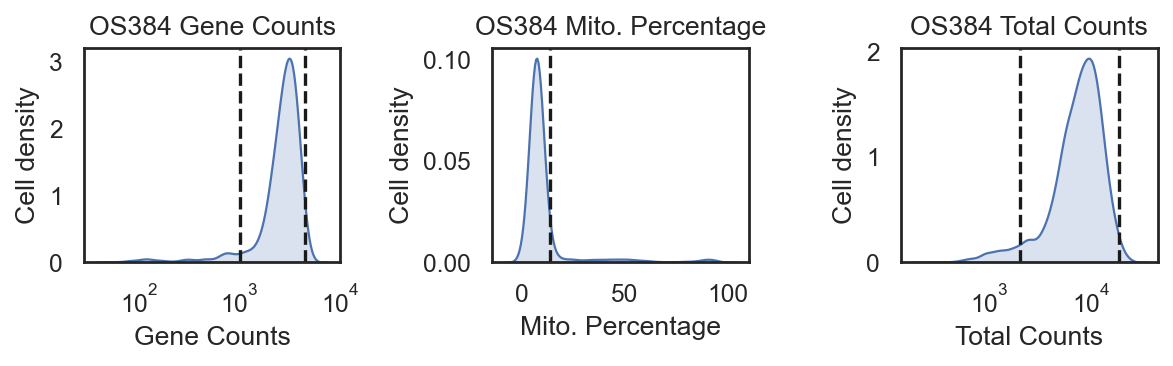

Filtered out 53345 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv
import scanpy as sc
import pandas as pd
import collections
import numpy as np
import matplotlib
import networkx
import fsspec
import anndata
import network
import igraph
import scvi
import h5py
import desc 
import umap
import h5py
import os

%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)
sc.set_figure_params(figsize=(4, 4))


# Reading in OS384 loom file
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS384/OS384.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Data for the variables
variables = [
    ('n_genes_by_counts', [(4500, '--'), (1000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(2000, '--'), (19000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS384 {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")

    
# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS384_filtering_plain.svg")


# Show the plot
plt.show()


# Filtering the dataset
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)




# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)


# Log scaling
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

#genes = adata.var.index.values

In [2]:

cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]

97
75
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    594 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    548 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [ ]:

sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

sc.tl.umap(adata)



sc.tl.leiden(adata, resolution = 0.55)

# making the var names unique
adata.var_names_make_unique()


genes = adata.var.index.values


# Plotting the umap based on leiden clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 Clusters",
    size = 20
)

# Marker identification with PCA dim reduction

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


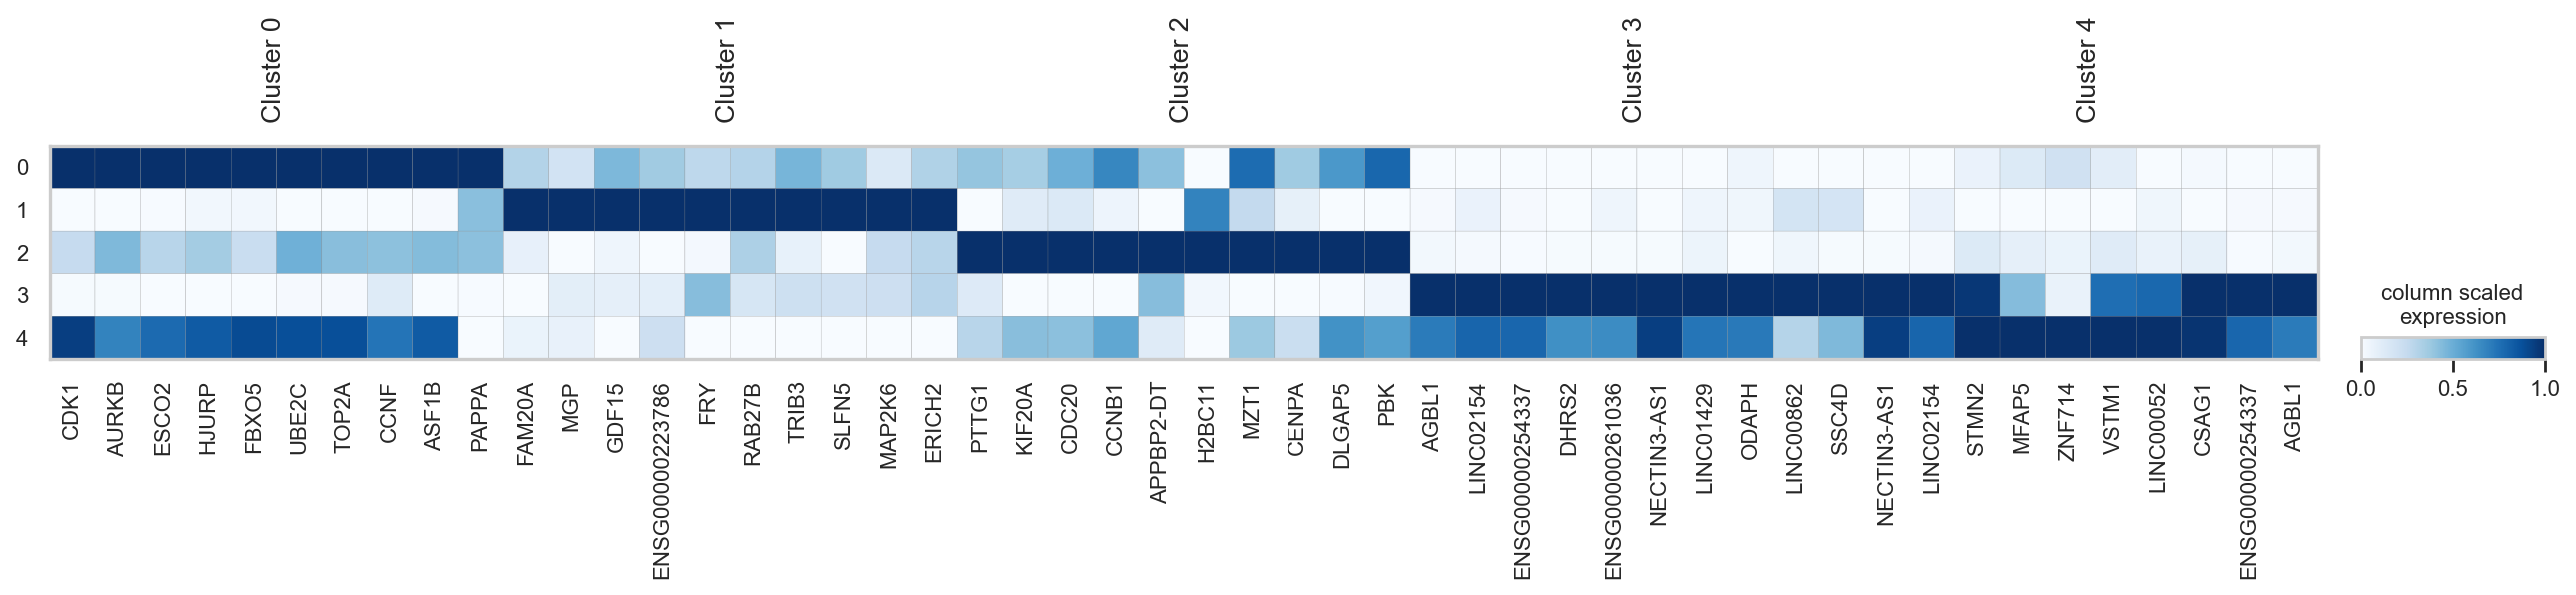

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,0,1,2,3,4
0,AURKB,COL1A1,PTTG1,RPS4X,LINC02154
1,UBE2C,COL1A2,JPT1,LINC02154,RPS4X
2,CDK1,COL6A3,HSP90AB1,AGBL1,COL8A1
3,TOP2A,PHGDH,UBE2S,COL8A1,CSAG1
4,TUBB,ITGA11,H2AZ1,CSAG1,GMNN
5,HMGB2,ARL4C,VIM,STMN2,HMGB2
6,DIAPH3,NEAT1,CDKN3,FTH1,STMN2
7,UBE2T,HLA-A,MT2A,KRT8,FABP4
8,CLSPN,SQSTM1,TUBA1B,HAPLN1,CDK1
9,KPNA2,TRIB3,CDC20,FTL,TNNT1


In [10]:
# Perform Differential Gene Expression Analysis
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')


# Extract gene names and log fold changes into a DataFrame
gene_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logfc_df = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])


# Filter for logFC > 1. This involves checking each gene's logFC across all clusters
# and selecting the gene if it has logFC > 1 in any of the clusters.
filtered_genes = gene_names_df[logfc_df > 1].stack().reset_index(level=1, drop=True).unique()

top_genes_by_cluster = {}  # Dictionary to hold top genes for each cluster

# Assuming gene_names_df and logfc_df have been correctly defined as before
num_clusters = gene_names_df.shape[1]

for cluster_idx in range(num_clusters):
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    top_genes_by_cluster[f"Cluster {cluster_idx}"] = top_genes
    
sc.pl.matrixplot(
    adata,
    top_genes_by_cluster,
    "leiden",
    #dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')


cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)


cluster_markers

<Figure size 800x640 with 0 Axes>

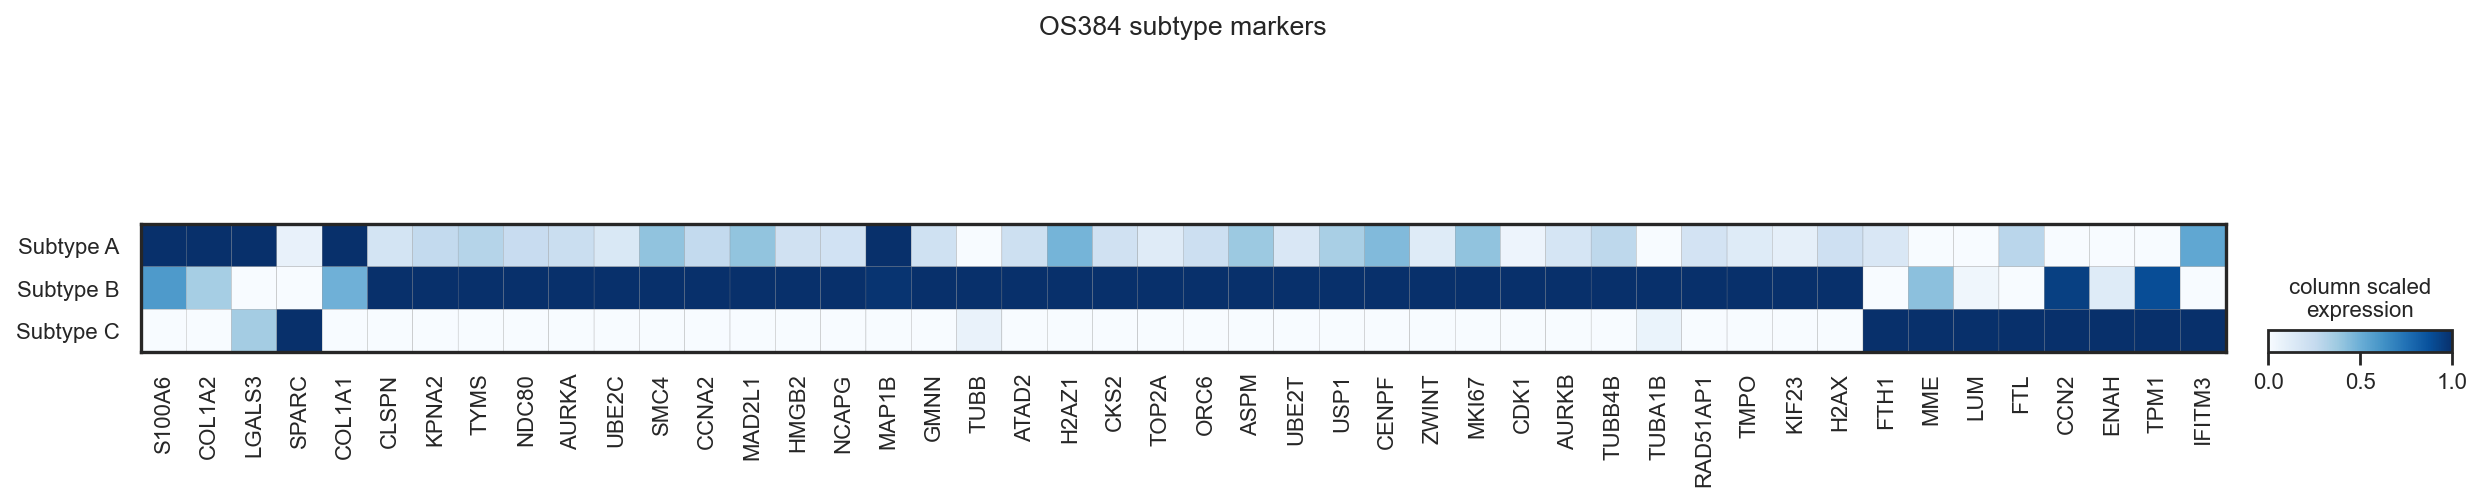

In [14]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes

Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes))



# You might want to remove these missing genes from your list before plotting
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]

# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]

# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in Subtype_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['subtype'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['subtype'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(10, 8))  # You can adjust the size as needed


# Plotting with Scanpy on the created figure
ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='Subtype',
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS384 subtype markers",
    show=False  # Do not display the plot immediately
)

# Save matrix plot as svg
plt.savefig("/Users/brendamelano/Desktop/OS384_subtype_markers.svg", format='svg')

plt.show()

plt.close()  # Close the plot to free up memory

# Identifying Subtype A markers

computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    109 total control genes are used. (0:00:00)


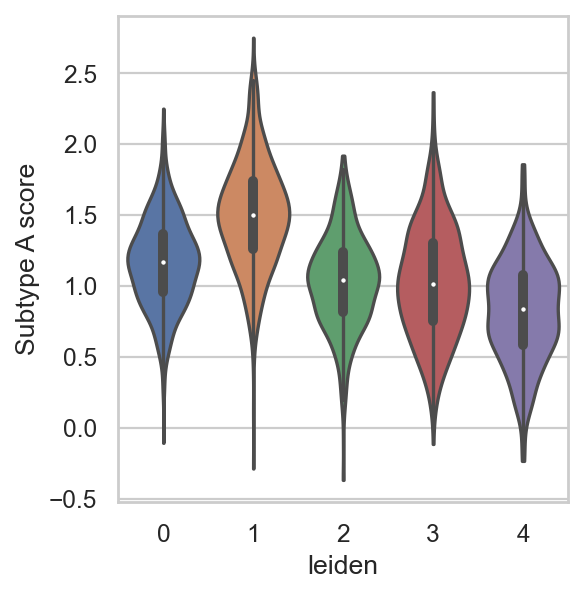

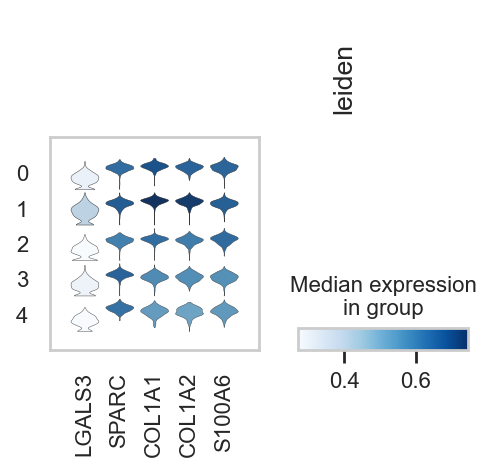

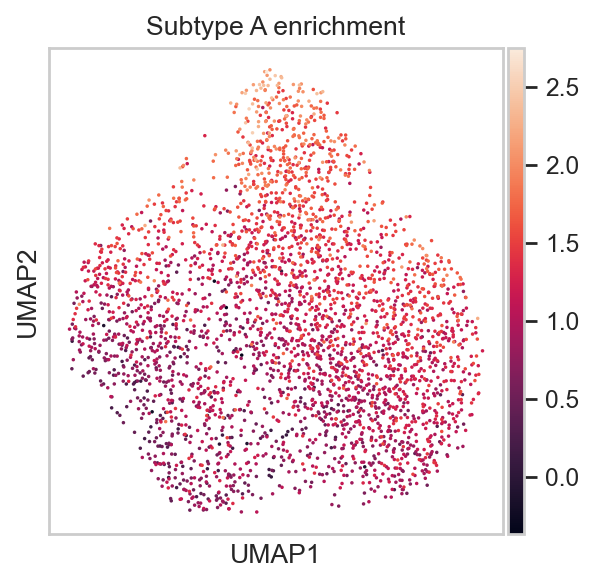

In [11]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '1'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_A_markers

Subtype_A_genes_384 = cluster_markers.iloc[:, 1].tolist()

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_A_markers.csv", Subtype_A_genes_384, delimiter=",", fmt='%s')


# Subtype B marker identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '0'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_B_markers

OS384_subtype_B_markers = OS384_subtype_B_markers.iloc[:, 0].tolist()

OS384_subtype_B_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_B_markers.csv", OS384_subtype_B_markers, delimiter=",", fmt='%s')


,genes,p_values,adjusted_p_values,log_fold_changes,scores
2,CDK1,3.130214e-135,1.565107e-132,2.528506,24.749613
1,AURKB,1.324512e-137,9.933837e-135,2.374106,24.969105
18,HJURP,2.617752e-65,1.963314e-63,2.199638,17.066891
13,FBXO5,2.922923e-72,3.131703e-70,2.129969,17.977516
0,UBE2C,2.161089e-138,3.241634e-135,2.117594,25.041494
3,TOP2A,4.470170e-121,1.676314e-118,2.046645,23.398081
42,FAM83D,9.743836e-46,3.247945e-44,1.889596,14.195679
56,ASF1B,9.376400e-40,2.383831e-38,1.764749,13.194993
11,NDC80,5.602714e-77,7.003392e-75,1.726455,18.570168
31,CKAP2L,1.048086e-52,4.764027e-51,1.689574,15.279458


# Subtype module enrichment

computing score 'Subtype_A_score'
    finished: added
    'Subtype_A_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)


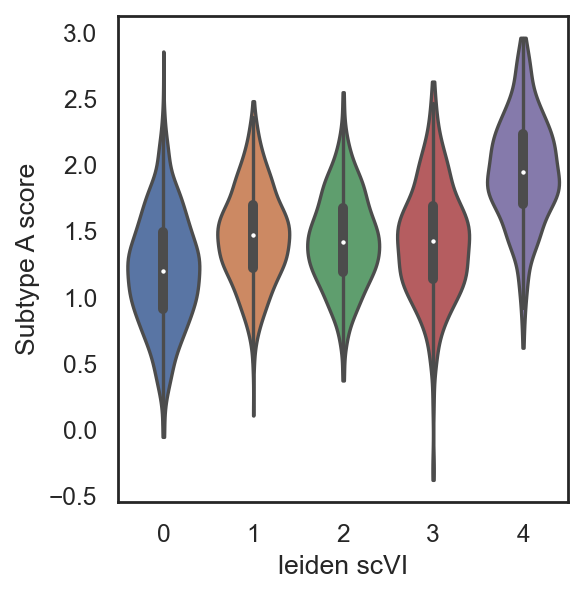

In [7]:
# Reading in Subtype "A" gene lists for gsea
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


# Ensuring that the var names are unique
adata.var_names_make_unique()


# keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_A_score', random_state=0, copy=False, use_raw=None)


# Plotting Subtype A score across clusters
sc.pl.violin(adata, ['Subtype_A_score'], groupby='leiden_scVI', stripplot=False, inner='box', 
             ylabel = 'Subtype A score')


# Subtype C Marker identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '3'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_C_markers = OS384_subtype_C_markers.iloc[:, 0].tolist()

OS384_subtype_C_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_C_markers.csv", OS384_subtype_C_markers, delimiter=",", fmt='%s')


['AGBL1',
 'LINC02154',
 'DHRS2',
 'ENSG00000254337',
 'NECTIN3-AS1',
 'STMN2',
 'POSTN',
 'CSAG1',
 'IL13RA2',
 'COL8A1',
 'TNFRSF9',
 'LCP1',
 'KRT8',
 'FABP4',
 'TNNT1',
 'MME',
 'GREM1',
 'CDKN1C',
 'IGFBP5',
 'PRICKLE1',
 'HAPLN1',
 'BABAM2',
 'SUGCT',
 'S100A2',
 'LMCD1',
 'LUM',
 'TLE4',
 'SNAI2',
 'SBF2-AS1',
 'SNHG18',
 'CDA',
 'NUAK1',
 'RPS4X',
 'FTH1',
 'PHLDB2',
 'GPNMB',
 'ARID5B',
 'CCN2',
 'COL11A1',
 'DCBLD2',
 'PAWR',
 'PMEPA1',
 'FRMD6',
 'PDLIM1',
 'IFITM3',
 'TCEAL9',
 'TP53I3',
 'BNIP3',
 'IGF1R',
 'ITGA11',
 'FTL',
 'ENAH',
 'ZFP36L1',
 'FHL1',
 'LIMS1',
 'NNMT',
 'UBC',
 'TMSB4X',
 'TPM1',
 'H3-3B']

computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    339 total control genes are used. (0:00:00)


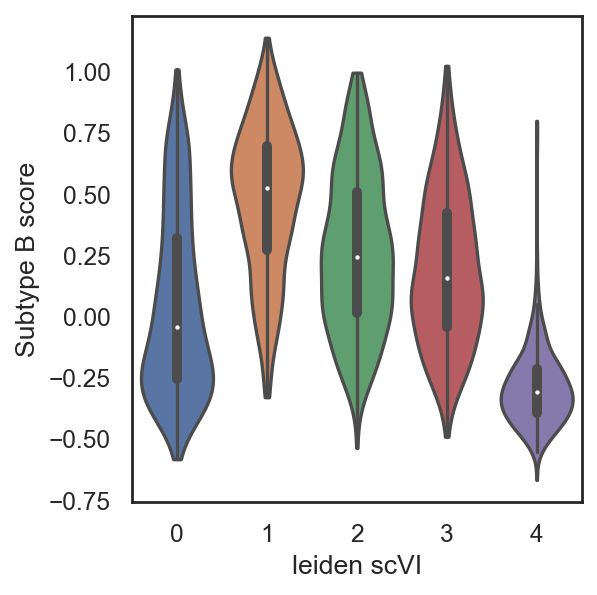

computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)


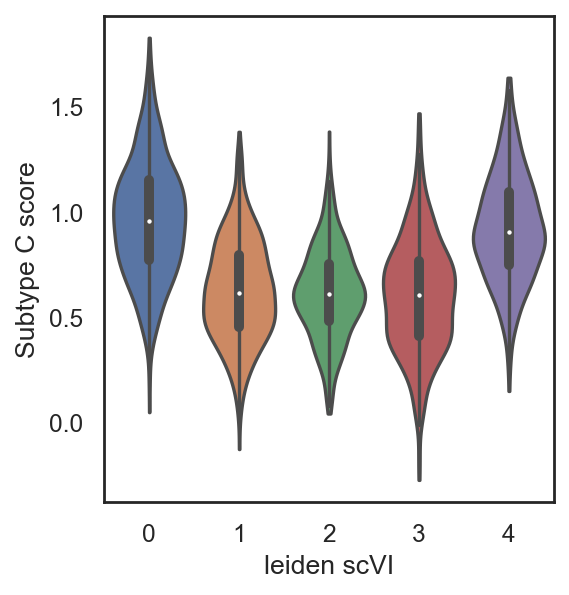

In [8]:
# Computing subtype B score
# reading in gene lists for gsea
subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_B_genes = [x for x in subtype_B_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden_scVI', stripplot=False, inner='box', 
             ylabel = 'Subtype B score')


# reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden_scVI', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')


# Label subtypes

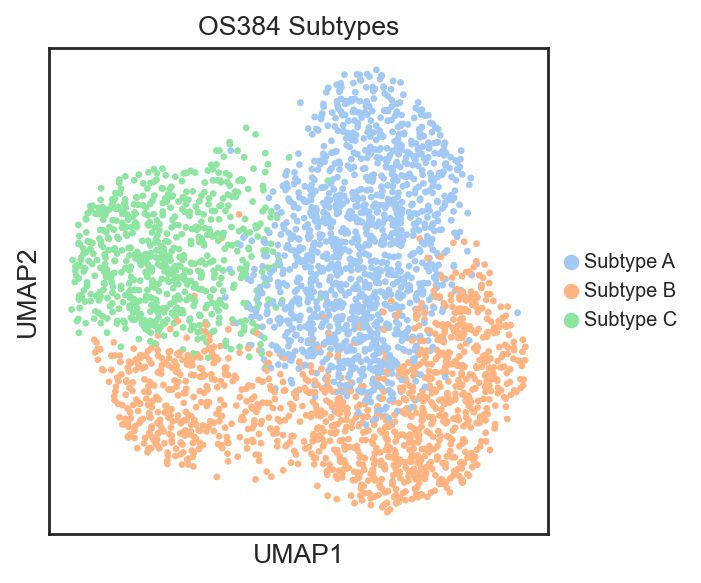

In [5]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='1']='3'
adata.obs['leiden'][adata.obs['leiden']=='0']='4'



# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['4'],  'Subtype B': ['3'], 'Subtype C':['2']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


# Create a dictionary that maps each cluster ID to a color from the palette
subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]


sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS384 Subtypes", palette = subtype_colors)


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384/OS384_PCA_subtype.h5ad")


# scVI

In [ ]:
# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS384:').rstrip('x'))


# reading in the cell IDs
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/cellID_obs_384.csv")


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,sample_obs["x"])]


# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/percent.mt.csv")



In [2]:

# filtering genes
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)


# normalizing the counts
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)


# log normalizing the data
sc.pp.log1p(adata)
#adata.raw = adata # freeze the state in `.raw`


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3500, # try 3k or 4k
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██| 400/400 [06:29<00:00,  1.06it/s, loss=1.37e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██| 400/400 [06:29<00:00,  1.03it/s, loss=1.37e+03, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


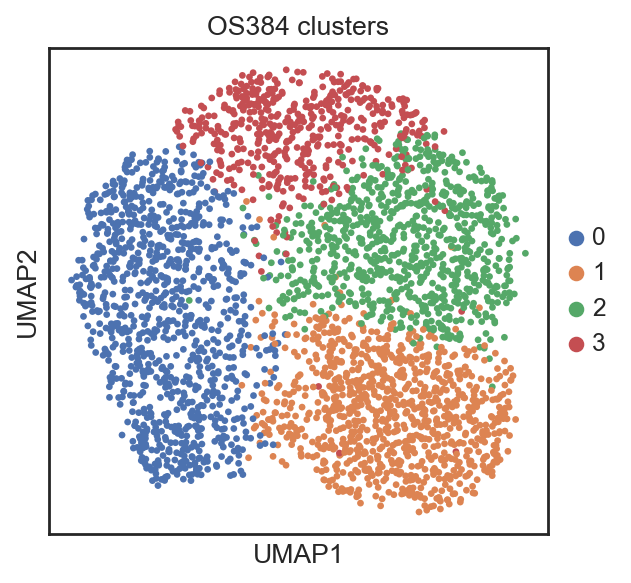

In [4]:
adata = adata.copy()

# setting up the anndata object to include categorical and continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)

# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

# reading in the adata file from the data integration script
#adata = scvi.read("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# saving my model
#model.save("OS384_scvi_model/")

# loading the model
#model = scvi.model.SCVI.load("OS384_scvi_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()


# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)


# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True,
    title = 'OS384 clusters'#,
    #save = "OS384_LT_umap.svg"
)


# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)


# Define the number of clusters
n_clusters = len(clusters[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]


# saving the adata file with the cluster ids
#adata.write("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# RNA velocity with scVelo

Normalized count data: spliced, unspliced.
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:01)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/751 [00:00<?, ?gene/s]

    finished (0:03:37) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3244 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


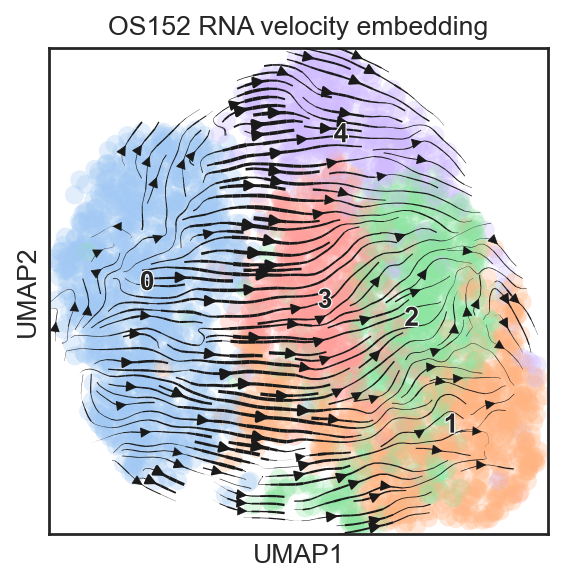

In [9]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden_scVI', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)

# saving the adata file with the cluster ids
#adata.write("/Users/brendamelano/Desktop/OS384_adata_labeled.h5ad")



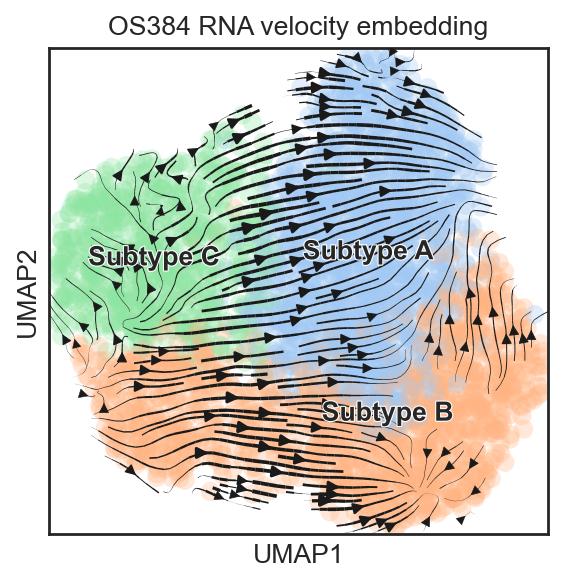

In [7]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='Subtype', 
                                 palette=colors, title = 'OS384 RNA velocity embedding',
                                frameon = True)

<Figure size 200x200 with 0 Axes>

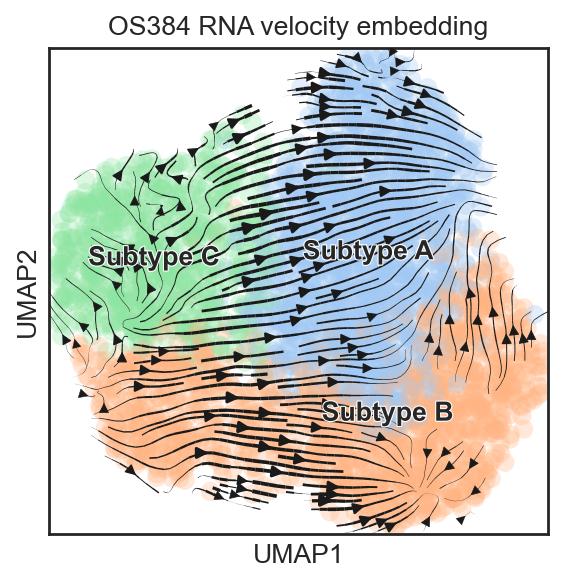

<Figure size 320x320 with 0 Axes>

In [12]:
# Create a figure explicitly
plt.figure(figsize=(2.5, 2.5))  # You can adjust the size as needed


# Plotting with Scanpy on the created figure
ax = scv.pl.velocity_embedding_stream(adata, basis='umap', color='Subtype', 
                                 palette=colors, 
                                 title='OS384 RNA velocity embedding', frameon=True)

# Save matrix plot as svg
plt.savefig("/Users/brendamelano/Desktop/OS384_subtype_markers.svg", format='svg')

plt.show()

plt.close()  # Close the plot to free up memory

# GSEA

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'


    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    194 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)


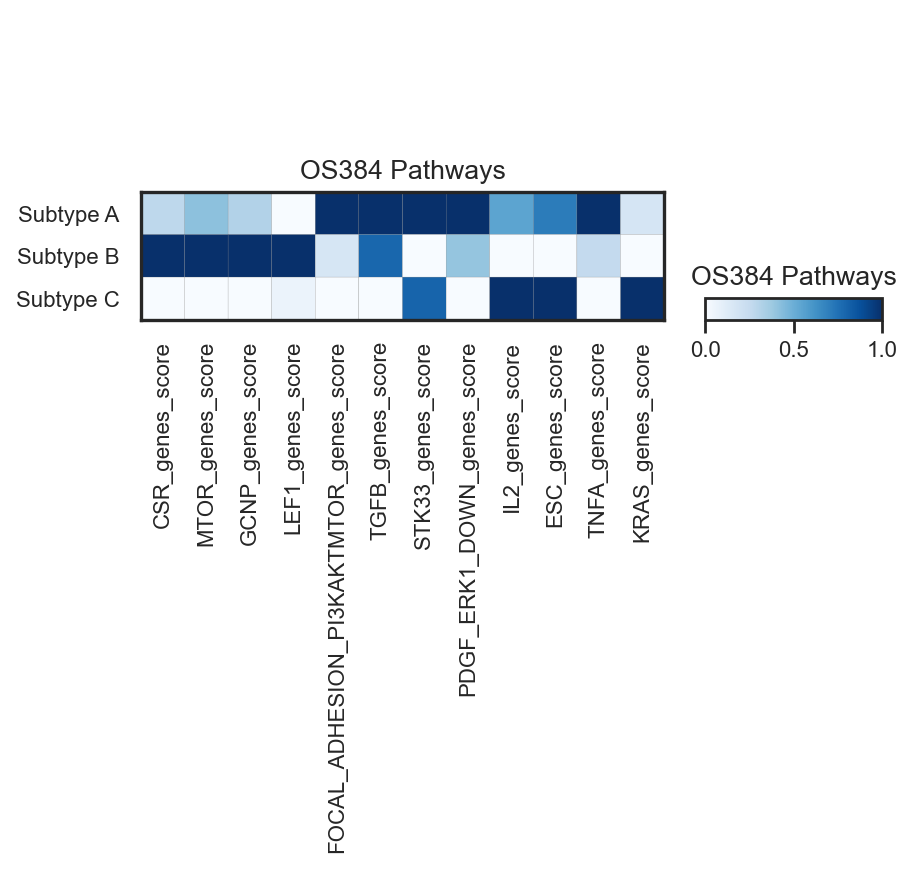

In [17]:
# Defining the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
adata.var_names_make_unique()


scores = ['CSR_genes_score','MTOR_genes_score', 'GCNP_genes_score','LEF1_genes_score',
          'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'TGFB_genes_score',   'STK33_genes_score',
          'PDGF_ERK1_DOWN_genes_score','IL2_genes_score',
         'ESC_genes_score',  'TNFA_genes_score', 'KRAS_genes_score']


axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "Subtype",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)

# Add a title to each plot in the dictionary, or modify as needed for specific axes
for ax in axes_dict.values():
    ax.set_title('OS384 Pathways', fontsize=12)

# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS384_Pathways.svg', format='svg')  # Adjust path as needed

# Show the plot if desired
plt.show()

# Cell type labeling for scVI

In [10]:
# Converting the cluster to category type
adata.obs['leiden_scVI'] = adata.obs['leiden_scVI'].astype('category')

adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='2']='3'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['1'], 'Subtype B': ['0'], 'Subtype C': ['3']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i
    
    
# Plotting the subtype labeled umap
sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9)
